In [1]:
import os
import math
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 11})
import matplotlib.ticker as ticker
# PyTorch
import torch
# GPyTorch
from gpytorch.mlls import ExactMarginalLogLikelihood
# BOTorch
import botorch
from botorch.models import SingleTaskGP
from botorch.models.transforms import Normalize, Standardize
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import LogExpectedImprovement
from botorch.optim import optimize_acqf

In [2]:
def print_job(
    alpha, beta, criterion, dataset, dataset_directory, experiments_directory, 
    lr_0, model_arch, n, prior_directory, prior_type, random_state, save, tune
):
    model_name = f'{criterion}_alpha={alpha}_beta={beta}_lr_0={lr_0}_n={n}_random_state={random_state}'
    if os.path.exists(f'{experiments_directory}/{model_name}.csv'):
        temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
        n_train = n - int((1/5) * n) if tune else n
        if check_epochs(temp_df, n_train, batch_size=min(128, n_train), steps=6000, drop_last=True):
        #if check_epochs(temp_df, n_train, batch_size=min(32, n_train), steps=12000, drop_last=False):
            return

    command = (
        f"python ../src/main_{dataset}.py "
        f"--alpha={alpha} "
        f"--beta={beta} "
        "--batch_size=128 "
        f"--criterion='{criterion}' "
        f"--dataset_directory='{dataset_directory}' "
        f"--experiments_directory='{experiments_directory}' "
        f"--lr_0={lr_0} "
        f"--model_arch='{model_arch}' "
        f"--model_name='{model_name}' "
        f"--n={n} "
        "--num_workers=0 "
        f"--prior_directory='{prior_directory}' "
        f"--prior_type='{prior_type}' "
        f"--random_state={random_state} "
        f"{'--save' if save else ''}"
        f"{'--tune' if tune else ''}"
    )
    
    print(f'    "{command}"')
    
def check_epochs(df, n, batch_size=128, steps=6000, drop_last=True):
    num_batches = math.floor(n/batch_size)# if drop_last else math.ceil(n/batch_size)
    epochs = int(steps/num_batches)
    return True if df.shape[0] == epochs else False

def get_runtime(alpha, beta, criterion, experiments_directory, lr_0, n, random_state, tune):
    model_name = f'{criterion}_alpha={alpha}_beta={beta}_lr_0={lr_0}_n={n}_random_state={random_state}'
    if not os.path.exists(f'{experiments_directory}/{model_name}.csv'):
        return 0.0
        #raise FileNotFoundError(f'Expected file not found: {experiments_directory}/{model_name}.csv')
    df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    n_train = n - int((1/5) * n) if tune else n
    if not check_epochs(df, n_train, batch_size=min(128, n_train), steps=6000, drop_last=True):
    #if not check_epochs(df, n_train, batch_size=min(32, n_train), steps=12000, drop_last=False):
        return 0.0
        #raise RuntimeError(f'Run incomplete: {model_name} did not run for the specified number of epochs')
    return df['train_sec/epoch'].sum()

def get_val_or_test_acc(alpha, beta, criterion, experiments_directory, lr_0, n, random_state, tune):
    model_name = f'{criterion}_alpha={alpha}_beta={beta}_lr_0={lr_0}_n={n}_random_state={random_state}'
    if not os.path.exists(f'{experiments_directory}/{model_name}.csv'):
        return 0.0
        #raise FileNotFoundError(f'Expected file not found: {experiments_directory}/{model_name}.csv')
    df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    n_train = n - int((1/5) * n) if tune else n
    if not check_epochs(df, n_train, batch_size=min(128, n_train), steps=6000, drop_last=True):
    #if not check_epochs(df, n_train, batch_size=min(32, n_train), steps=12000, drop_last=False):
        return 0.0
        #raise RuntimeError(f'Run incomplete: {model_name} did not run for the specified number of epochs')
    return df['val_or_test_acc'].values[-1]
    
def get_val_or_test_nll(alpha, beta, criterion, experiments_directory, lr_0, n, random_state, tune):
    model_name = f'{criterion}_alpha={alpha}_beta={beta}_lr_0={lr_0}_n={n}_random_state={random_state}'
    if not os.path.exists(f'{experiments_directory}/{model_name}.csv'):
        return 10.0
        #raise FileNotFoundError(f'Expected file not found: {experiments_directory}/{model_name}.csv')
    df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    n_train = n - int((1/5) * n) if tune else n
    if not check_epochs(df, n_train, batch_size=min(128, n_train), steps=6000, drop_last=True):
    #if not check_epochs(df, n_train, batch_size=min(32, n_train), steps=12000, drop_last=False):
        return 10.0
        #raise RuntimeError(f'Run incomplete: {model_name} did not run for the specified number of epochs')
    return df['val_or_test_nll'].values[-1]

def get_candidate(train_X, train_Y, seed):
    
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    gp = SingleTaskGP(
        train_X=train_X,
        train_Y=train_Y,
        input_transform=Normalize(d=3),
        outcome_transform=Standardize(m=1),
    )
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)

    logEI = LogExpectedImprovement(model=gp, best_f=train_Y.max())

    bounds = torch.stack([torch.zeros(3), torch.ones(3)]).to(torch.double)
    candidate, acq_value = optimize_acqf(
      logEI, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
    )
    
    return candidate.detach()

In [3]:
# DONE:

# CIFAR-10 n_iters = 7 retrained
# New-4 n_iters = 8 retrained

# CIFAR-10 n_iters = 11 tuned
# New-4 n_iters = 9 tuned

# TODO:

# CIFAR-10 n_iters = 12 tuned
# New-4 n_iters = 10 tuned


In [4]:
# DONE:

# CIFAR-10 n_iters = 11 retrained
# New-4 n_iters = 11 retrained

# CIFAR-10 n_iters = 11 tuned
# New-4 n_iters = 11 tuned

# TODO:

# CIFAR-10 n_iters = 12 retrained
# New-4 n_iters = 12 retrained

# CIFAR-10 n_iters = 12 tuned
# New-4 n_iters = 12 tuned


In [5]:
# ViT-B/16

# DONE:

# CIFAR-10 n_iters = 4 tuned

# TODO:

# CIFAR-10 n_iters = 5 tuned

In [7]:
criterion = 'l2-sp'
dataset = 'CIFAR-10'
dataset_directory = '/cluster/tufts/hugheslab/eharve06/CIFAR-10'
model_arch = 'ViT-B/16'
ns = [100, 1000, 10000, 50000]
n_iters = 6
prior_directory = '/cluster/tufts/hugheslab/eharve06/vit_b_16_torchvision'
prior_type = 'vit_b_16_torchvision'
random_states = [1001, 2001, 3001]
retrained_experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_CIFAR-10_ViT_B_16_BO'
tuned_experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/tuned_CIFAR-10_ViT_B_16_BO'
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

bounds = torch.tensor([[-6, -6, -4], [-2, -2, -1]], dtype=torch.double)

columns = ['alpha', 'beta', 'lr_0', 'n', 'n_iter', 'random_state', 'runtime', 'seed', 'val_acc', 'val_nll', 'test_acc', 'test_nll']
cifar10_bo_df = pd.DataFrame(columns=columns)

for n, random_state, seed in itertools.product(ns, random_states, seeds):

    gen = torch.Generator()
    gen.manual_seed(seed)

    train_X = torch.rand(size=(1, 3,), generator=gen, dtype=torch.double)
    train_X_bounded = (bounds[1]-bounds[0]) * train_X + bounds[0]
    
    alpha, beta, lr_0 = 10**train_X_bounded[0]
    print_job(alpha, beta, criterion, dataset, dataset_directory, tuned_experiments_directory, lr_0, model_arch, n, prior_directory, prior_type, random_state, False, True)

    train_Y = torch.tensor([[-get_val_or_test_nll(10**x[0], 10**x[1], criterion, tuned_experiments_directory, 10**x[2], n, random_state, True)] for x in train_X_bounded], dtype=torch.float64)
    
    alpha_star, beta_star, lr_0_star = 10**train_X_bounded[torch.argmax(train_Y)]
    print_job(alpha_star, beta_star, criterion, dataset, dataset_directory, retrained_experiments_directory, lr_0_star, model_arch, n, prior_directory, prior_type, random_state, True, False)
    
    runtime = 0.0
    runtime = get_runtime(alpha, beta, criterion, tuned_experiments_directory, lr_0, n, random_state, True)
    runtime += get_runtime(alpha_star, beta_star, criterion, retrained_experiments_directory, lr_0_star, n, random_state, False)
    
    val_acc = get_val_or_test_acc(alpha, beta, criterion, tuned_experiments_directory, lr_0, n, random_state, True)
    val_nll = get_val_or_test_nll(alpha, beta, criterion, tuned_experiments_directory, lr_0, n, random_state, True)
    test_acc = get_val_or_test_acc(alpha_star, beta_star, criterion, retrained_experiments_directory, lr_0_star, n, random_state, False)
    test_nll = get_val_or_test_nll(alpha_star, beta_star, criterion, retrained_experiments_directory, lr_0_star, n, random_state, False)

    row = [alpha.item(), beta.item(), lr_0.item(), n, 0, random_state, runtime, seed, val_acc, val_nll, test_acc, test_nll]
    cifar10_bo_df.loc[len(cifar10_bo_df)] = row
    
    for i in range(1, n_iters+1):

        candidate = get_candidate(train_X, train_Y, seed)
        candidate_bounded = (bounds[1]-bounds[0]) * candidate + bounds[0]
        train_X = torch.cat([train_X, candidate])
        train_X_bounded = (bounds[1]-bounds[0]) * train_X + bounds[0]
                
        alpha, beta, lr_0 = 10**candidate_bounded[0]
        print_job(alpha, beta, criterion, dataset, dataset_directory, tuned_experiments_directory, lr_0, model_arch, n, prior_directory, prior_type, random_state, False, True)

        train_Y = torch.tensor([[-get_val_or_test_nll(10**x[0], 10**x[1], criterion, tuned_experiments_directory, 10**x[2], n, random_state, True)] for x in train_X_bounded], dtype=torch.float64)

        alpha_star, beta_star, lr_0_star = 10**train_X_bounded[torch.argmax(train_Y)]
        #print_job(alpha_star, beta_star, criterion, dataset, dataset_directory, retrained_experiments_directory, lr_0_star, model_arch, n, prior_directory, prior_type, random_state, True, False)
        
        runtime = 0.0
        runtime = sum([get_runtime(10**x[0], 10**x[1], criterion, tuned_experiments_directory, 10**x[2], n, random_state, True) for x in train_X_bounded])
        runtime += get_runtime(alpha_star, beta_star, criterion, retrained_experiments_directory, lr_0_star, n, random_state, False)
        
        val_acc = get_val_or_test_acc(alpha, beta, criterion, tuned_experiments_directory, lr_0, n, random_state, True)
        val_nll = get_val_or_test_nll(alpha, beta, criterion, tuned_experiments_directory, lr_0, n, random_state, True)
        test_acc = get_val_or_test_acc(alpha_star, beta_star, criterion, retrained_experiments_directory, lr_0_star, n, random_state, False)
        test_nll = get_val_or_test_nll(alpha_star, beta_star, criterion, retrained_experiments_directory, lr_0_star, n, random_state, False)

        row = [alpha.item(), beta.item(), lr_0.item(), n, i, random_state, runtime, seed, val_acc, val_nll, test_acc, test_nll]
        cifar10_bo_df.loc[len(cifar10_bo_df)] = row

cifar10_bo_df.head(100)

    "python ../src/main_CIFAR-10.py --alpha=1e-06 --beta=1e-06 --batch_size=128 --criterion='l2-sp' --dataset_directory='/cluster/tufts/hugheslab/eharve06/CIFAR-10' --experiments_directory='/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/tuned_CIFAR-10_ViT_B_16_BO' --lr_0=0.0007878228573524851 --model_arch='ViT-B/16' --model_name='l2-sp_alpha=1e-06_beta=1e-06_lr_0=0.0007878228573524851_n=100_random_state=1001' --n=100 --num_workers=0 --prior_directory='/cluster/tufts/hugheslab/eharve06/vit_b_16_torchvision' --prior_type='vit_b_16_torchvision' --random_state=1001 --tune"
    "python ../src/main_CIFAR-10.py --alpha=0.01 --beta=1e-06 --batch_size=128 --criterion='l2-sp' --dataset_directory='/cluster/tufts/hugheslab/eharve06/CIFAR-10' --experiments_directory='/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/tuned_CIFAR-10_ViT_B_16_BO' --lr_0=0.0004994921203216744 --model_arch='ViT-B/16' --model_name='l2-sp_alpha=0.01_beta=1e-06_lr_0=0.000499492120321674

    "python ../src/main_CIFAR-10.py --alpha=3.21487658160519e-06 --beta=5.0407118551420536e-06 --batch_size=128 --criterion='l2-sp' --dataset_directory='/cluster/tufts/hugheslab/eharve06/CIFAR-10' --experiments_directory='/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/tuned_CIFAR-10_ViT_B_16_BO' --lr_0=0.0004389399988100325 --model_arch='ViT-B/16' --model_name='l2-sp_alpha=3.21487658160519e-06_beta=5.0407118551420536e-06_lr_0=0.0004389399988100325_n=100_random_state=2001' --n=100 --num_workers=0 --prior_directory='/cluster/tufts/hugheslab/eharve06/vit_b_16_torchvision' --prior_type='vit_b_16_torchvision' --random_state=2001 --tune"
    "python ../src/main_CIFAR-10.py --alpha=1e-06 --beta=0.001113980126480708 --batch_size=128 --criterion='l2-sp' --dataset_directory='/cluster/tufts/hugheslab/eharve06/CIFAR-10' --experiments_directory='/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/tuned_CIFAR-10_ViT_B_16_BO' --lr_0=0.0001 --model_arch='ViT-B/16' --

    "python ../src/main_CIFAR-10.py --alpha=1.537658357591551e-06 --beta=1.66865314625913e-05 --batch_size=128 --criterion='l2-sp' --dataset_directory='/cluster/tufts/hugheslab/eharve06/CIFAR-10' --experiments_directory='/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/tuned_CIFAR-10_ViT_B_16_BO' --lr_0=0.1 --model_arch='ViT-B/16' --model_name='l2-sp_alpha=1.537658357591551e-06_beta=1.66865314625913e-05_lr_0=0.1_n=1000_random_state=1001' --n=1000 --num_workers=0 --prior_directory='/cluster/tufts/hugheslab/eharve06/vit_b_16_torchvision' --prior_type='vit_b_16_torchvision' --random_state=1001 --tune"
    "python ../src/main_CIFAR-10.py --alpha=1e-06 --beta=1e-06 --batch_size=128 --criterion='l2-sp' --dataset_directory='/cluster/tufts/hugheslab/eharve06/CIFAR-10' --experiments_directory='/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/tuned_CIFAR-10_ViT_B_16_BO' --lr_0=0.0001 --model_arch='ViT-B/16' --model_name='l2-sp_alpha=1e-06_beta=1e-06_lr_0=0.000

    "python ../src/main_CIFAR-10.py --alpha=0.01 --beta=1e-06 --batch_size=128 --criterion='l2-sp' --dataset_directory='/cluster/tufts/hugheslab/eharve06/CIFAR-10' --experiments_directory='/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/tuned_CIFAR-10_ViT_B_16_BO' --lr_0=0.03484388163093529 --model_arch='ViT-B/16' --model_name='l2-sp_alpha=0.01_beta=1e-06_lr_0=0.03484388163093529_n=1000_random_state=2001' --n=1000 --num_workers=0 --prior_directory='/cluster/tufts/hugheslab/eharve06/vit_b_16_torchvision' --prior_type='vit_b_16_torchvision' --random_state=2001 --tune"
    "python ../src/main_CIFAR-10.py --alpha=0.0033617203262637976 --beta=1e-06 --batch_size=128 --criterion='l2-sp' --dataset_directory='/cluster/tufts/hugheslab/eharve06/CIFAR-10' --experiments_directory='/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/tuned_CIFAR-10_ViT_B_16_BO' --lr_0=0.0001 --model_arch='ViT-B/16' --model_name='l2-sp_alpha=0.0033617203262637976_beta=1e-06_lr_0=0.000

    "python ../src/main_CIFAR-10.py --alpha=0.005969295743639255 --beta=0.01 --batch_size=128 --criterion='l2-sp' --dataset_directory='/cluster/tufts/hugheslab/eharve06/CIFAR-10' --experiments_directory='/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/tuned_CIFAR-10_ViT_B_16_BO' --lr_0=0.1 --model_arch='ViT-B/16' --model_name='l2-sp_alpha=0.005969295743639255_beta=0.01_lr_0=0.1_n=10000_random_state=1001' --n=10000 --num_workers=0 --prior_directory='/cluster/tufts/hugheslab/eharve06/vit_b_16_torchvision' --prior_type='vit_b_16_torchvision' --random_state=1001 --tune"
    "python ../src/main_CIFAR-10.py --alpha=2.140708740408662e-05 --beta=2.8072041793886962e-06 --batch_size=128 --criterion='l2-sp' --dataset_directory='/cluster/tufts/hugheslab/eharve06/CIFAR-10' --experiments_directory='/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/tuned_CIFAR-10_ViT_B_16_BO' --lr_0=0.007778189926161143 --model_arch='ViT-B/16' --model_name='l2-sp_alpha=2.1407087404

    "python ../src/main_CIFAR-10.py --alpha=1e-06 --beta=0.01 --batch_size=128 --criterion='l2-sp' --dataset_directory='/cluster/tufts/hugheslab/eharve06/CIFAR-10' --experiments_directory='/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/tuned_CIFAR-10_ViT_B_16_BO' --lr_0=0.0012240553031631952 --model_arch='ViT-B/16' --model_name='l2-sp_alpha=1e-06_beta=0.01_lr_0=0.0012240553031631952_n=10000_random_state=2001' --n=10000 --num_workers=0 --prior_directory='/cluster/tufts/hugheslab/eharve06/vit_b_16_torchvision' --prior_type='vit_b_16_torchvision' --random_state=2001 --tune"
    "python ../src/main_CIFAR-10.py --alpha=1e-06 --beta=1e-06 --batch_size=128 --criterion='l2-sp' --dataset_directory='/cluster/tufts/hugheslab/eharve06/CIFAR-10' --experiments_directory='/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/tuned_CIFAR-10_ViT_B_16_BO' --lr_0=0.00048048592897646927 --model_arch='ViT-B/16' --model_name='l2-sp_alpha=1e-06_beta=1e-06_lr_0=0.0004804859289

    "python ../src/main_CIFAR-10.py --alpha=1e-06 --beta=1.1541964018177312e-05 --batch_size=128 --criterion='l2-sp' --dataset_directory='/cluster/tufts/hugheslab/eharve06/CIFAR-10' --experiments_directory='/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/tuned_CIFAR-10_ViT_B_16_BO' --lr_0=0.1 --model_arch='ViT-B/16' --model_name='l2-sp_alpha=1e-06_beta=1.1541964018177312e-05_lr_0=0.1_n=50000_random_state=1001' --n=50000 --num_workers=0 --prior_directory='/cluster/tufts/hugheslab/eharve06/vit_b_16_torchvision' --prior_type='vit_b_16_torchvision' --random_state=1001 --tune"
    "python ../src/main_CIFAR-10.py --alpha=1e-06 --beta=6.311674551047616e-06 --batch_size=128 --criterion='l2-sp' --dataset_directory='/cluster/tufts/hugheslab/eharve06/CIFAR-10' --experiments_directory='/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/tuned_CIFAR-10_ViT_B_16_BO' --lr_0=0.003178740983165928 --model_arch='ViT-B/16' --model_name='l2-sp_alpha=1e-06_beta=6.3116745510

    "python ../src/main_CIFAR-10.py --alpha=0.01 --beta=0.01 --batch_size=128 --criterion='l2-sp' --dataset_directory='/cluster/tufts/hugheslab/eharve06/CIFAR-10' --experiments_directory='/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/tuned_CIFAR-10_ViT_B_16_BO' --lr_0=0.00017166944193786453 --model_arch='ViT-B/16' --model_name='l2-sp_alpha=0.01_beta=0.01_lr_0=0.00017166944193786453_n=50000_random_state=3001' --n=50000 --num_workers=0 --prior_directory='/cluster/tufts/hugheslab/eharve06/vit_b_16_torchvision' --prior_type='vit_b_16_torchvision' --random_state=3001 --tune"
    "python ../src/main_CIFAR-10.py --alpha=0.0014768911756061105 --beta=1e-06 --batch_size=128 --criterion='l2-sp' --dataset_directory='/cluster/tufts/hugheslab/eharve06/CIFAR-10' --experiments_directory='/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/tuned_CIFAR-10_ViT_B_16_BO' --lr_0=0.0001 --model_arch='ViT-B/16' --model_name='l2-sp_alpha=0.0014768911756061105_beta=1e-06_lr_0

,alpha,beta,lr_0,n,n_iter,random_state,runtime,seed,val_acc,val_nll,test_acc,test_nll
0,0.007589,0.000678,0.002389,100.0,0.0,1001.0,11962.895370,0.0,0.75,0.664725,0.8786,0.382506
1,0.000001,0.000001,0.100000,100.0,1.0,1001.0,17262.992587,0.0,0.50,2.772601,0.8786,0.382506
2,0.001950,0.001412,0.000690,100.0,2.0,1001.0,22437.080971,0.0,0.70,0.795896,0.8786,0.382506
3,0.010000,0.007690,0.040400,100.0,3.0,1001.0,27527.874768,0.0,0.50,1.683694,0.8786,0.382506
4,0.010000,0.000087,0.000550,100.0,4.0,1001.0,32718.751672,0.0,0.70,0.790889,0.8786,0.382506
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000001,0.010000,0.000100,100.0,4.0,2001.0,32238.639835,3.0,0.80,0.910873,0.8407,0.533245
96,0.000001,0.000001,0.000100,100.0,5.0,2001.0,37324.777794,3.0,0.80,0.910655,0.8407,0.533245
97,0.000001,0.000047,0.000304,100.0,6.0,2001.0,37324.777794,3.0,0.00,10.000000,0.8407,0.533245
98,0.000081,0.000845,0.000149,100.0,0.0,2001.0,12403.804395,4.0,0.80,0.888936,0.8432,0.504143


In [4]:
cifar10_bo_grouped_df = cifar10_bo_df.groupby(['n', 'n_iter', 'random_state']).agg(lambda x: tuple(x))
columns = ['runtime', 'val_acc', 'test_acc']
for column in columns:
    cifar10_bo_grouped_df[f'{column}_mean'] = cifar10_bo_grouped_df[column].apply(lambda item: np.mean(item))
    cifar10_bo_grouped_df[f'{column}_std'] = cifar10_bo_grouped_df[column].apply(lambda item: np.std(item))
    cifar10_bo_grouped_df[f'{column}_min'] = cifar10_bo_grouped_df[column].apply(lambda item: np.min(item))
    cifar10_bo_grouped_df[f'{column}_max'] = cifar10_bo_grouped_df[column].apply(lambda item: np.max(item))
cifar10_bo_grouped_df = cifar10_bo_grouped_df.reset_index()
cifar10_bo_grouped_df

,n,n_iter,random_state,alpha,beta,lr_0,runtime,seed,val_acc,val_nll,...,runtime_min,runtime_max,val_acc_mean,val_acc_std,val_acc_min,val_acc_max,test_acc_mean,test_acc_std,test_acc_min,test_acc_max
0,100.0,0.0,1001.0,"(0.00758947976208385, 1.7547413041177135e-06, ...","(0.0006780776932355295, 7.91075667332751e-06, ...","(0.0023886297077207034, 0.0005043796336040412,...","(11962.895370483398, 11807.528914690018, 12480...","(0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","(0.7500000596046448, 0.7000000476837158, 0.850...","(0.6647253632545471, 0.7910665273666382, 0.551...",...,11405.739176,12480.728403,0.71500,0.050249,0.6500,0.8500,0.86562,0.023926,0.7958,0.8839
1,100.0,0.0,2001.0,"(0.00758947976208385, 1.7547413041177135e-06, ...","(0.0006780776932355295, 7.91075667332751e-06, ...","(0.0023886297077207034, 0.0005043796336040412,...","(11679.747871875763, 12200.262169599533, 13223...","(0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","(0.7500000596046448, 0.8000000715255737, 0.750...","(0.8652288317680359, 0.8627112507820129, 0.842...",...,11348.726504,13223.383870,0.72000,0.105357,0.5000,0.8000,0.84428,0.020948,0.7836,0.8607
2,100.0,0.0,3001.0,"(0.00758947976208385, 1.7547413041177135e-06, ...","(0.0006780776932355295, 7.91075667332751e-06, ...","(0.0023886297077207034, 0.0005043796336040412,...","(12473.836394548416, 11823.332378864288, 12995...","(0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","(0.9000000953674316, 0.9500001072883606, 0.900...","(0.273183524608612, 0.2836540341377258, 0.2467...",...,11453.769759,12995.895526,0.92500,0.040311,0.8500,1.0000,0.87475,0.013037,0.8367,0.8867
3,100.0,1.0,1001.0,"(1.1021585497520294e-06, 0.0034424767798646888...","(1e-06, 0.01, 0.008424264162555345, 0.01, 1e-0...","(0.1, 0.06409990349943775, 0.0001, 0.0001, 0.1...","(17262.9925866127, 17124.7800719738, 17701.493...","(0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","(0.5000000596046448, 0.6500000357627869, 0.700...","(2.772601366043091, 1.368361234664917, 0.81365...",...,16716.555469,19261.644725,0.66500,0.077621,0.5000,0.7500,0.87619,0.004895,0.8706,0.8839
4,100.0,1.0,2001.0,"(1.1021585497520294e-06, 0.0034424767798646888...","(1e-06, 0.01, 0.008424264162555345, 0.01, 1e-0...","(0.1, 0.06409990349943775, 0.0001, 0.0001, 0.1...","(16867.967819929123, 17428.19018626213, 18424....","(0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","(0.6000000238418579, 0.5, 0.8000000715255737, ...","(2.8174386024475098, 2.187788248062134, 0.9108...",...,16552.049005,18424.972996,0.66500,0.176139,0.3500,0.8000,0.85120,0.008998,0.8411,0.8656
5,100.0,1.0,3001.0,"(1.1021585497520294e-06, 0.0034424767798646888...","(1e-06, 0.01, 0.008424264162555345, 0.01, 1e-0...","(0.1, 0.06409990349943775, 0.0001, 0.0001, 0.1...","(17667.434554100037, 17037.82369017601, 18273....","(0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","(0.7000001072883606, 0.7000000476837158, 0.900...","(1.1672998666763306, 1.2642762660980225, 0.458...",...,16621.409804,18273.732075,0.78500,0.170367,0.3500,0.9000,0.88001,0.005401,0.8734,0.8926
6,100.0,2.0,1001.0,"(0.0019502930714389664, 1.3272474258517135e-05...","(0.0014123121476753515, 5.758773309475701e-06,...","(0.00068990213875323, 0.00013531904249966753, ...","(22437.08097076416, 22293.22289967537, 22898.0...","(0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","(0.7000000476837158, 0.7000000476837158, 0.800...","(0.7958955764770508, 0.7997800707817078, 0.650...",...,21918.426455,24427.411377,0.73000,0.050990,0.7000,0.8500,0.87639,0.004812,0.8706,0.8839
7,100.0,2.0,2001.0,"(0.003957550157854984, 1.3272472989952234e-05,...","(0.0014861540327960375, 5.7587728359146334e-06...","(0.0006311177830362597, 0.00013531903533073363...","(21986.67927646637, 22629.42376923561, 23674.0...","(0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","(0.8000000715255737, 0.8000000715255737, 0.750...","(0.857787013053894, 0.8939693570137024, 1.1041...",...,21814.804589,23674.049445,0.78000,0.024495,0.7500,0.8000,0.85197,0.008416,0.8407,0.8656
8,

In [5]:
cifar10_dictionary = np.load('CIFAR-10_ViT_B_16_dictionary.npy', allow_pickle=True).item()

In [6]:
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_CIFAR-10_ViT_B_16_VI'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
criterion = 'l2-sp'
ns = [100, 1000, 10000, 50000]
random_states = [1001, 2001, 3001]

columns = ['criterion', 'model_name', 'n', 'random_state', 'runtime', 'train_loss', 'test_acc', 'test_nll']
cifar10_elbo_tuned_df = pd.DataFrame(columns=columns)

for lr_0, n, random_state in itertools.product(lr_0s, ns, random_states):
    model_name = f'{criterion}_kappa=1.0_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [criterion, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.train_loss.values[-1], temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    cifar10_elbo_tuned_df.loc[len(cifar10_elbo_tuned_df)] = row
    
min_indices = cifar10_elbo_tuned_df.groupby(['criterion', 'n', 'random_state'])['train_loss'].idxmin()
cifar10_elbo_retrained_df = cifar10_elbo_tuned_df.loc[min_indices]
cifar10_elbo_retrained_df['total_time'] = cifar10_elbo_tuned_df.groupby(['criterion', 'n', 'random_state'])['runtime'].sum().values   

In [7]:
#d = 23528522
d = 85806346
#d = 27827818
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_CIFAR-10_ViT_B_16_VI'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
criterion = 'l2-sp'
ns = [100, 1000, 10000, 50000]
random_states = [1001, 2001, 3001]

columns = ['criterion', 'model_name', 'n', 'random_state', 'runtime', 'train_loss', 'test_acc', 'test_nll']
cifar10_de_elbo_tuned_df = pd.DataFrame(columns=columns)

for lr_0, n, random_state in itertools.product(lr_0s, ns, random_states):
    model_name = f'{criterion}_kappa={d/n}_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [criterion, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.train_loss.values[-1], temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    cifar10_de_elbo_tuned_df.loc[len(cifar10_de_elbo_tuned_df)] = row
    
min_indices = cifar10_de_elbo_tuned_df.groupby(['criterion', 'n', 'random_state'])['train_loss'].idxmin()
cifar10_de_elbo_retrained_df = cifar10_de_elbo_tuned_df.loc[min_indices]
cifar10_de_elbo_retrained_df['total_time'] = cifar10_de_elbo_tuned_df.groupby(['criterion', 'n', 'random_state'])['runtime'].sum().values   

In [8]:
def plot_dictionary(ax, bootstrap_dictionary, n, random_states, color='#1F77B4', markers=['o', '^', 's']):
    for index, random_state in enumerate(random_states):
        x = bootstrap_dictionary[n][random_state][:,:,:,0].mean(axis=(0,2,))
        y = bootstrap_dictionary[n][random_state][:,:,:,1].mean(axis=(0,2,))
        lower_x, upper_x = np.percentile(bootstrap_dictionary[n][random_state][:,:,:,0].mean(axis=(2,)), [2.5, 97.5], axis=(0,))
        lower_y, upper_y = np.percentile(bootstrap_dictionary[n][random_state][:,:,:,1].mean(axis=(2,)), [2.5, 97.5], axis=(0,))
        ax.scatter(x[-1]/3600, y[-1], color=color, marker=markers[index], zorder=3)
        ax.plot(x/3600, y, color=color, zorder=2)
        ax.fill_between(x/3600, lower_y, upper_y, alpha=0.1, color=color, zorder=2)

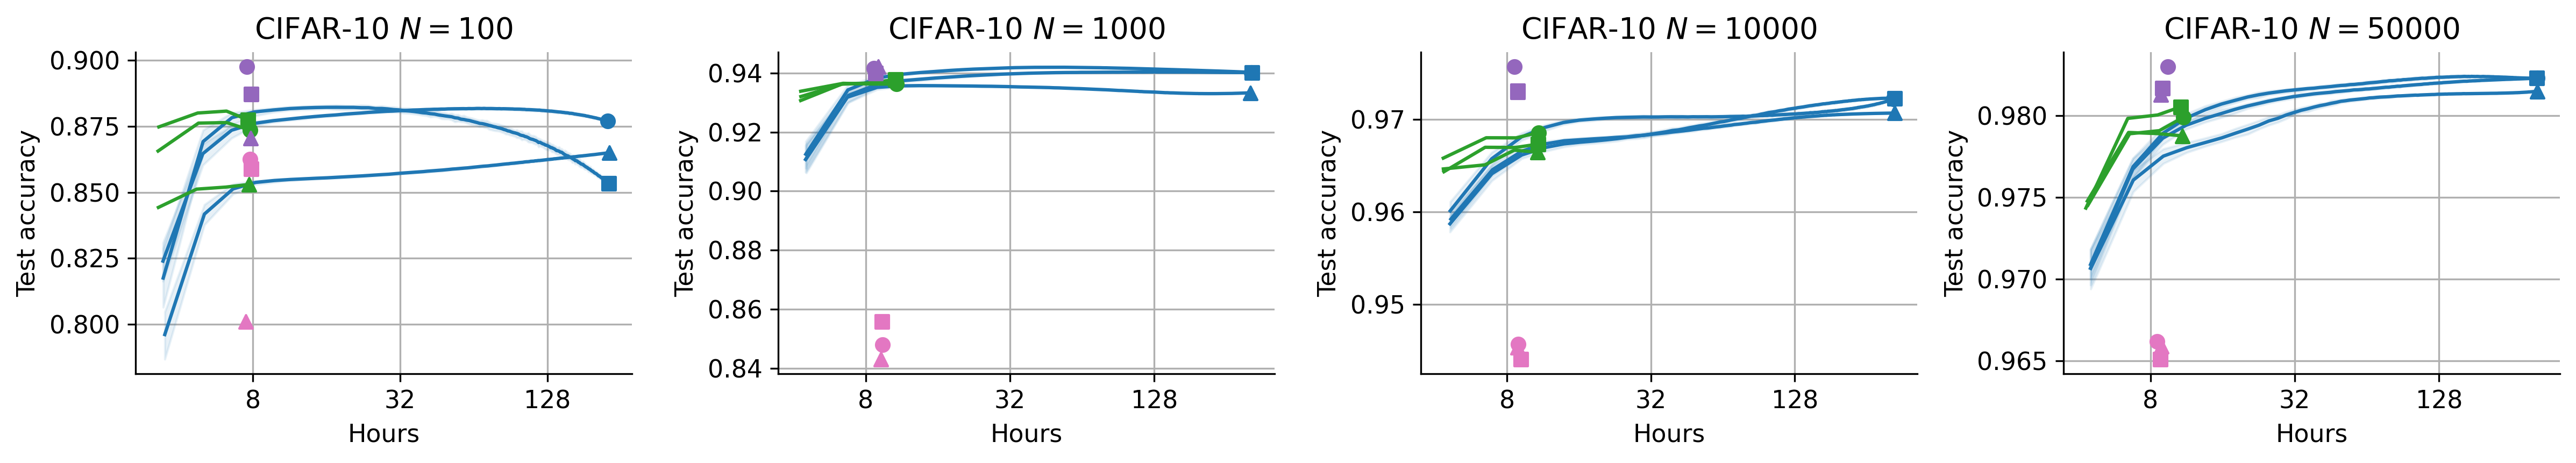

In [9]:
def break_axes(ax):
    d = 0.015
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (0.525 - d, 0.525 + d), **kwargs)
    ax.plot((-d, +d), (0.475 - d, 0.475 + d), **kwargs)
    
def decorate_ax(ax, title):
    ax.set_title(title)
    ax.set_xlabel('Hours')
    ax.set_ylabel('Test accuracy')
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xscale('log', base=2)
    ax_xticks = ax.get_xticks()
    ax.set_xticks([int(ax_xtick) for ax_xtick in ax_xticks[2:-2]], [int(ax_xtick) for ax_xtick in ax_xticks[2:-2]])
    ax.grid()
    
def decorate_hidden_ax(ax, title):
    ax.set_title(title)
    ax.set_xlabel('Hours')
    ax.set_ylabel('Test accuracy')
    ax.spines[['bottom', 'top', 'left', 'right']].set_visible(False)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax.tick_params(axis='x', color=(0, 0, 0, 0), labelcolor=(0, 0, 0, 0), which='both')
    ax.tick_params(axis='y', color=(0, 0, 0, 0), labelcolor=(0, 0, 0, 0), which='both')
    
def decorate_broken_axes(ax1, ax2):
    
    ax1.spines[['bottom', 'top', 'right']].set_visible(False)
    ax2.spines[['right', 'top']].set_visible(False)
        
    ax1.set_xscale('log', base=2)
    ax2.set_xscale('log', base=2)
    ax1_xlim = ax1.get_xlim()
    ax1_xticks = ax1.get_xticks()
    ax1.set_xticks([int(ax1_xtick) for ax1_xtick in ax1_xticks[2:-2]], [int(ax1_xtick) for ax1_xtick in ax1_xticks[2:-2]])
    ax1.tick_params(axis='x', color=(0, 0, 0, 0), labelcolor=(0, 0, 0, 0), which='both')
    ax2.set_xlim(ax1_xlim)
    ax2.set_xticks([int(ax1_xtick) for ax1_xtick in ax1_xticks[2:-2]], [int(ax1_xtick) for ax1_xtick in ax1_xticks[2:-2]])
    
    ax1_distance = ax1.get_ylim()[1] - ax1.get_ylim()[0]
    ax2_mean = sum(ax2.get_ylim())/2
    ax2_distance = [max(0.0, ax2_mean - (ax1_distance/2)), max(ax2_mean + (ax1_distance/2) - (ax2_mean - (ax1_distance/2)), ax2_mean + (ax1_distance/2))]
    ax2.scatter(4*np.ones_like(ax2_distance), ax2_distance, color='#FFFFFF')
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(round(ax1.get_yticks()[-1] - ax1.get_yticks()[-2], 3)))
    if len(ax2.get_yticks()) > 5:
        ax2.yaxis.set_major_locator(ticker.AutoLocator())
    ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    
    ax1.grid()
    ax2.grid()
    
markers = ['o', '^', 's']
    
ncols, nrows = 4, 1
fig, axs = plt.subplots(dpi=300, figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows)

# Plot 1
plot_dictionary(axs[0], cifar10_dictionary, 100, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==100].total_time.values/3600, cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==100].test_acc.values)):
    axs[0].scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(cifar10_de_elbo_retrained_df[cifar10_de_elbo_retrained_df.n==100].total_time.values/3600, cifar10_de_elbo_retrained_df[cifar10_de_elbo_retrained_df.n==100].test_acc.values)):
    axs[0].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
    
for index, random_state in enumerate([1001, 2001, 3001]):
    temp_df = cifar10_bo_grouped_df[(cifar10_bo_grouped_df.n==100)&(cifar10_bo_grouped_df.random_state==random_state)]
    temp_df = temp_df.sort_values('n_iter')
    axs[0].scatter(temp_df.runtime_mean.values[-1]/3600, temp_df.test_acc_mean.values[-1], color='#2CA02C', marker=markers[index], zorder=2)
    axs[0].plot(temp_df.runtime_mean.values/3600, temp_df.test_acc_mean.values, color='#2CA02C', zorder=2)
    
decorate_ax(axs[0], r'CIFAR-10 $N=100$')

# Plot 2
plot_dictionary(axs[1], cifar10_dictionary, 1000, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==1000].total_time.values/3600, cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==1000].test_acc.values)):
    axs[1].scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(cifar10_de_elbo_retrained_df[cifar10_de_elbo_retrained_df.n==1000].total_time.values/3600, cifar10_de_elbo_retrained_df[cifar10_de_elbo_retrained_df.n==1000].test_acc.values)):
    axs[1].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
    
for index, random_state in enumerate([1001, 2001, 3001]):
    temp_df = cifar10_bo_grouped_df[(cifar10_bo_grouped_df.n==1000)&(cifar10_bo_grouped_df.random_state==random_state)]
    temp_df = temp_df.sort_values('n_iter')
    axs[1].scatter(temp_df.runtime_mean.values[-1]/3600, temp_df.test_acc_mean.values[-1], color='#2CA02C', marker=markers[index], zorder=2)
    axs[1].plot(temp_df.runtime_mean.values/3600, temp_df.test_acc_mean.values, color='#2CA02C', zorder=2)
    
decorate_ax(axs[1], r'CIFAR-10 $N=1000$')

# Plot 3
plot_dictionary(axs[2], cifar10_dictionary, 10000, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==10000].total_time.values/3600, cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==10000].test_acc.values)):
    axs[2].scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(cifar10_de_elbo_retrained_df[cifar10_de_elbo_retrained_df.n==10000].total_time.values/3600, cifar10_de_elbo_retrained_df[cifar10_de_elbo_retrained_df.n==10000].test_acc.values)):
    axs[2].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
    
for index, random_state in enumerate([1001, 2001, 3001]):
    temp_df = cifar10_bo_grouped_df[(cifar10_bo_grouped_df.n==10000)&(cifar10_bo_grouped_df.random_state==random_state)]
    temp_df = temp_df.sort_values('n_iter')
    axs[2].scatter(temp_df.runtime_mean.values[-1]/3600, temp_df.test_acc_mean.values[-1], color='#2CA02C', marker=markers[index], zorder=2)
    axs[2].plot(temp_df.runtime_mean.values/3600, temp_df.test_acc_mean.values, color='#2CA02C', zorder=2)
    
decorate_ax(axs[2], r'CIFAR-10 $N=10000$')

# Plot 4
plot_dictionary(axs[3], cifar10_dictionary, 50000, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==50000].total_time.values/3600, cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==50000].test_acc.values)):
    axs[3].scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(cifar10_de_elbo_retrained_df[cifar10_de_elbo_retrained_df.n==50000].total_time.values/3600, cifar10_de_elbo_retrained_df[cifar10_de_elbo_retrained_df.n==50000].test_acc.values)):
    axs[3].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
    
for index, random_state in enumerate([1001, 2001, 3001]):
    temp_df = cifar10_bo_grouped_df[(cifar10_bo_grouped_df.n==50000)&(cifar10_bo_grouped_df.random_state==random_state)]
    temp_df = temp_df.sort_values('n_iter')
    axs[3].scatter(temp_df.runtime_mean.values[-1]/3600, temp_df.test_acc_mean.values[-1], color='#2CA02C', marker=markers[index], zorder=2)
    axs[3].plot(temp_df.runtime_mean.values/3600, temp_df.test_acc_mean.values, color='#2CA02C', zorder=2)
    
decorate_ax(axs[3], r'CIFAR-10 $N=50000$')

fig.tight_layout()
plt.show()

In [3]:
criterion = 'l2-sp'
dataset = 'AG_News'
dataset_directory = '/cluster/tufts/hugheslab/eharve06/AG_News'
model_arch = ''
ns = [40000, 120000]
n_iters = 11
prior_directory = ''
prior_type = ''
random_states = [1001, 2001, 3001]
retrained_experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_AG_News_BO'
tuned_experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/tuned_AG_News_BO'
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

bounds = torch.tensor([[-6, -6, -4], [-2, -2, -1]], dtype=torch.double)

columns = ['alpha', 'beta', 'lr_0', 'n', 'n_iter', 'random_state', 'runtime', 'seed', 'val_acc', 'val_nll', 'test_acc', 'test_nll']
news10_bo_df = pd.DataFrame(columns=columns)

for n, random_state, seed in itertools.product(ns, random_states, seeds):

    gen = torch.Generator()
    gen.manual_seed(seed)

    train_X = torch.rand(size=(1, 3,), generator=gen, dtype=torch.double)
    train_X_bounded = (bounds[1]-bounds[0]) * train_X + bounds[0]
    
    alpha, beta, lr_0 = 10**train_X_bounded[0]
    print_job(alpha, beta, criterion, dataset, dataset_directory, tuned_experiments_directory, lr_0, model_arch, n, prior_directory, prior_type, random_state, False, True)

    train_Y = torch.tensor([[-get_val_or_test_nll(10**x[0], 10**x[1], criterion, tuned_experiments_directory, 10**x[2], n, random_state, True)] for x in train_X_bounded], dtype=torch.float64)
    
    alpha_star, beta_star, lr_0_star = 10**train_X_bounded[torch.argmax(train_Y)]
    print_job(alpha_star, beta_star, criterion, dataset, dataset_directory, retrained_experiments_directory, lr_0_star, model_arch, n, prior_directory, prior_type, random_state, True, False)
    
    runtime = 0.0
    runtime = get_runtime(alpha, beta, criterion, tuned_experiments_directory, lr_0, n, random_state, True)
    runtime += get_runtime(alpha_star, beta_star, criterion, retrained_experiments_directory, lr_0_star, n, random_state, False)
    
    val_acc = get_val_or_test_acc(alpha, beta, criterion, tuned_experiments_directory, lr_0, n, random_state, True)
    val_nll = get_val_or_test_nll(alpha, beta, criterion, tuned_experiments_directory, lr_0, n, random_state, True)
    test_acc = get_val_or_test_acc(alpha_star, beta_star, criterion, retrained_experiments_directory, lr_0_star, n, random_state, False)
    test_nll = get_val_or_test_nll(alpha_star, beta_star, criterion, retrained_experiments_directory, lr_0_star, n, random_state, False)

    row = [alpha.item(), beta.item(), lr_0.item(), n, 0, random_state, runtime, seed, val_acc, val_nll, test_acc, test_nll]
    news10_bo_df.loc[len(news10_bo_df)] = row
        
    for i in range(1, n_iters+1):

        candidate = get_candidate(train_X, train_Y, seed)
        candidate_bounded = (bounds[1]-bounds[0]) * candidate + bounds[0]
        train_X = torch.cat([train_X, candidate])
        train_X_bounded = (bounds[1]-bounds[0]) * train_X + bounds[0]

        alpha, beta, lr_0 = 10**candidate_bounded[0]
        print_job(alpha, beta, criterion, dataset, dataset_directory, tuned_experiments_directory, lr_0, model_arch, n, prior_directory, prior_type, random_state, False, True)

        train_Y = torch.tensor([[-get_val_or_test_nll(10**x[0], 10**x[1], criterion, tuned_experiments_directory, 10**x[2], n, random_state, True)] for x in train_X_bounded], dtype=torch.float64)

        alpha_star, beta_star, lr_0_star = 10**train_X_bounded[torch.argmax(train_Y)]
        print_job(alpha_star, beta_star, criterion, dataset, dataset_directory, retrained_experiments_directory, lr_0_star, model_arch, n, prior_directory, prior_type, random_state, True, False)

        runtime = 0.0
        runtime = sum([get_runtime(10**x[0], 10**x[1], criterion, tuned_experiments_directory, 10**x[2], n, random_state, True) for x in train_X_bounded])
        runtime += get_runtime(alpha_star, beta_star, criterion, retrained_experiments_directory, lr_0_star, n, random_state, False)

        val_acc = get_val_or_test_acc(alpha, beta, criterion, tuned_experiments_directory, lr_0, n, random_state, True)
        val_nll = get_val_or_test_nll(alpha, beta, criterion, tuned_experiments_directory, lr_0, n, random_state, True)
        test_acc = get_val_or_test_acc(alpha_star, beta_star, criterion, retrained_experiments_directory, lr_0_star, n, random_state, False)
        test_nll = get_val_or_test_nll(alpha_star, beta_star, criterion, retrained_experiments_directory, lr_0_star, n, random_state, False)

        row = [alpha.item(), beta.item(), lr_0.item(), n, i, random_state, runtime, seed, val_acc, val_nll, test_acc, test_nll]
        news10_bo_df.loc[len(news10_bo_df)] = row

news10_bo_df.head(100)

,alpha,beta,lr_0,n,n_iter,random_state,runtime,seed,val_acc,val_nll,test_acc,test_nll
0,0.007589,0.000678,0.002389,40000.0,0.0,1001.0,14682.265820,0.0,0.934875,0.020004,0.932500,0.020449
1,0.000001,0.000001,0.100000,40000.0,1.0,1001.0,22301.092462,0.0,0.250000,0.129966,0.932500,0.020449
2,0.004011,0.001500,0.000631,40000.0,2.0,1001.0,29777.094771,0.0,0.927000,0.019971,0.922368,0.021701
3,0.002254,0.010000,0.078326,40000.0,3.0,1001.0,37304.995549,0.0,0.911625,0.025204,0.922368,0.021701
4,0.004851,0.000001,0.100000,40000.0,4.0,1001.0,44933.403602,0.0,0.916750,0.025521,0.922368,0.021701
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000001,0.000001,0.001470,40000.0,11.0,1001.0,98403.808607,7.0,0.932750,0.019107,0.930000,0.020371
96,0.001360,0.000193,0.000214,40000.0,0.0,1001.0,14907.553491,8.0,0.912125,0.023456,0.908684,0.024769
97,0.000001,0.000001,0.100000,40000.0,1.0,1001.0,22467.267115,8.0,0.250000,0.129970,0.908684,0.024769
98,0.002509,0.001321,0.000134,40000.0,2.0,1001.0,30277.997782,8.0,0.905750,0.025177,0.908684,0.024769


In [4]:
new4_bo_grouped_df = news10_bo_df.groupby(['n', 'n_iter', 'random_state']).agg(lambda x: tuple(x))
columns = ['runtime', 'val_acc', 'test_acc']
for column in columns:
    new4_bo_grouped_df[f'{column}_mean'] = new4_bo_grouped_df[column].apply(lambda item: np.mean(item))
    new4_bo_grouped_df[f'{column}_std'] = new4_bo_grouped_df[column].apply(lambda item: np.std(item))
    new4_bo_grouped_df[f'{column}_min'] = new4_bo_grouped_df[column].apply(lambda item: np.min(item))
    new4_bo_grouped_df[f'{column}_max'] = new4_bo_grouped_df[column].apply(lambda item: np.max(item))
new4_bo_grouped_df = new4_bo_grouped_df.reset_index()
new4_bo_grouped_df

,n,n_iter,random_state,alpha,beta,lr_0,runtime,seed,val_acc,val_nll,...,runtime_min,runtime_max,val_acc_mean,val_acc_std,val_acc_min,val_acc_max,test_acc_mean,test_acc_std,test_acc_min,test_acc_max
0,40000.0,0.0,1001.0,"(0.00758947976208385, 1.7547413041177135e-06, ...","(0.0006780776932355295, 7.91075667332751e-06, ...","(0.0023886297077207034, 0.0005043796336040412,...","(14682.265820264816, 14728.69370174408, 14783....","(0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","(0.9348750114440918, 0.9237499833106996, 0.936...","(0.0200037903652992, 0.0205080923270434, 0.034...",...,14601.063778,14946.744869,0.928112,0.010224,0.906125,0.936375,0.857711,0.202833,0.250000,0.935395
1,40000.0,0.0,2001.0,"(0.00758947976208385, 1.7547413041177135e-06, ...","(0.0006780776932355295, 7.91075667332751e-06, ...","(0.0023886297077207034, 0.0005043796336040412,...","(14767.876569986343, 14750.065286159515, 14795...","(0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","(0.927625060081482, 0.9173749685287476, 0.9292...","(0.0231607628126512, 0.0234374159560538, 0.037...",...,14432.496850,14862.465971,0.921800,0.009904,0.902125,0.931750,0.925118,0.011086,0.903421,0.934737
2,40000.0,0.0,3001.0,"(0.00758947976208385, 1.7547413041177135e-06, ...","(0.0006780776932355295, 7.91075667332751e-06, ...","(0.0023886297077207034, 0.0005043796336040412,...","(14636.859175682068, 14973.604129076004, 14578...","(0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","(0.9358749985694884, 0.9235000014305116, 0.934...","(0.0204124147051479, 0.0216265652677975, 0.033...",...,14578.767353,14973.604129,0.927812,0.009161,0.909125,0.935875,0.857382,0.202706,0.250000,0.935526
3,40000.0,1.0,1001.0,"(1.1021585497520294e-06, 0.0034424767798646888...","(1e-06, 0.01, 0.008424264162555345, 0.01, 1e-0...","(0.1, 0.06409990349943775, 0.0001, 0.0001, 0.1...","(22301.092462062836, 22457.66979908943, 22481....","(0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","(0.25, 0.9338749647140504, 0.9021250009536744,...","(0.129965796366334, 0.0258485580599371, 0.0263...",...,22261.901010,22543.427379,0.716325,0.305574,0.250000,0.935000,0.915355,0.015057,0.898816,0.936053
4,40000.0,1.0,2001.0,"(1.1021585497520294e-06, 0.0034424767798646888...","(1e-06, 0.01, 0.008424264162555345, 0.01, 1e-0...","(0.1, 0.06409990349943775, 0.0001, 0.0001, 0.1...","(22278.569452285767, 22429.214097499847, 22451...","(0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","(0.25, 0.9320000410079956, 0.8962500095367432,...","(0.1299674031436442, 0.0282268907722755, 0.029...",...,21953.384858,22473.444976,0.713425,0.303769,0.250000,0.933750,0.911579,0.013517,0.897632,0.931842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,120000.0,10.0,2001.0,"(0.006420063331946842, 0.01, 7.188420105617289...","(0.0011921131810761559, 0.00014708758415585407...","(0.026989027028385095, 0.007692158052379239, 0...","(90212.32120132446, 90726.6260676384, 90994.17...","(0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","(0.9437083005905152, 0.9409999847412108, 0.899...","(0.0166259816783422, 0.017336247983796, 0.0292...",...,89885.733951,91445.447779,0.863892,0.205028,0.250000,0.943708,0.943118,0.003417,0.934211,0.945921
68,120000.0,10.0,3001.0,"(0.0061836879588036, 0.0076156140869619825, 0....","(1e-06, 0.00221106141288474, 0.01, 0.01, 0.01,...","(0.02140158062842961, 0.014715211656548127, 0....","(90552.28216814995, 90923.73360204697, 91017.5...","(0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","(0.9485000371932985, 0.9470416903495787, 0.945...","(0.015814658483956, 0.0159079746401403, 0.0161...",...,90327.746300,91124.543899,0.870779,0.207299,0.250000,0.948500,0.942776,0.003550,0.932632,0.945395
69,120000.0,11.0,1001.0,"(0.00618751897247598, 0.0036568411098819214, 1...","(0.0004728110920454669, 1e-06, 1e-06, 1e-06, 0...","(0.033937656760655965, 0.0075435135832492405, ...","(99207.1379058361, 98569.35046291351, 98974.60...","(0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","(0.94841665029

In [5]:
cifar10_dictionary = np.load('CIFAR-10_ResNet_50_dictionary.npy', allow_pickle=True).item()
news4_dictionary = np.load('AG_News_BERT-base_dictionary.npy', allow_pickle=True).item()

In [6]:
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_CIFAR-10_VI'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
criterion = 'l2-sp'
ns = [100, 1000, 10000, 50000]
random_states = [1001, 2001, 3001]

columns = ['criterion', 'model_name', 'n', 'random_state', 'runtime', 'train_loss', 'test_acc', 'test_nll']
cifar10_elbo_tuned_df = pd.DataFrame(columns=columns)

for lr_0, n, random_state in itertools.product(lr_0s, ns, random_states):
    model_name = f'{criterion}_kappa=1.0_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [criterion, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.train_loss.values[-1], temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    cifar10_elbo_tuned_df.loc[len(cifar10_elbo_tuned_df)] = row
    
min_indices = cifar10_elbo_tuned_df.groupby(['criterion', 'n', 'random_state'])['train_loss'].idxmin()
cifar10_elbo_retrained_df = cifar10_elbo_tuned_df.loc[min_indices]
cifar10_elbo_retrained_df['total_time'] = cifar10_elbo_tuned_df.groupby(['criterion', 'n', 'random_state'])['runtime'].sum().values   

In [7]:
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_CIFAR-10_diagEF'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
criterion = 'l2-sp'
ns = [100, 1000, 10000, 50000]
random_states = [1001, 2001, 3001]

columns = ['criterion', 'model_name', 'n', 'random_state', 'runtime', 'train_loss', 'test_acc', 'test_nll']
cifar10_laplace_tuned_df = pd.DataFrame(columns=columns)

for lr_0, n, random_state in itertools.product(lr_0s, ns, random_states):
    model_name = f'{criterion}_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [criterion, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.train_loss.values[-1], temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    cifar10_laplace_tuned_df.loc[len(cifar10_laplace_tuned_df)] = row
    
min_indices = cifar10_laplace_tuned_df.groupby(['criterion', 'n', 'random_state'])['train_loss'].idxmin()
cifar10_laplace_retrained_df = cifar10_laplace_tuned_df.loc[min_indices]
cifar10_laplace_retrained_df['total_time'] = cifar10_laplace_tuned_df.groupby(['criterion', 'n', 'random_state'])['runtime'].sum().values   

In [8]:
d = 23528522
#d = 85806346
#d = 27827818
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_CIFAR-10_VI'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
criterion = 'l2-sp'
ns = [100, 1000, 10000, 50000]
random_states = [1001, 2001, 3001]

columns = ['criterion', 'model_name', 'n', 'random_state', 'runtime', 'train_loss', 'test_acc', 'test_nll']
cifar10_de_elbo_tuned_df = pd.DataFrame(columns=columns)

for lr_0, n, random_state in itertools.product(lr_0s, ns, random_states):
    model_name = f'{criterion}_kappa={d/n}_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [criterion, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.train_loss.values[-1], temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    cifar10_de_elbo_tuned_df.loc[len(cifar10_de_elbo_tuned_df)] = row
    
min_indices = cifar10_de_elbo_tuned_df.groupby(['criterion', 'n', 'random_state'])['train_loss'].idxmin()
cifar10_de_elbo_retrained_df = cifar10_de_elbo_tuned_df.loc[min_indices]
cifar10_de_elbo_retrained_df['total_time'] = cifar10_de_elbo_tuned_df.groupby(['criterion', 'n', 'random_state'])['runtime'].sum().values   

In [9]:
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_AG_News_VI_SGD'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
criterion = 'l2-sp'
ns = [40, 400, 4_000, 40_000, 120_000]
random_states = [1001, 2001, 3001]

columns = ['criterion', 'model_name', 'n', 'random_state', 'runtime', 'train_loss', 'test_acc', 'test_nll']
news4_elbo_tuned_df = pd.DataFrame(columns=columns)

for lr_0, n, random_state in itertools.product(lr_0s, ns, random_states):
    model_name = f'{criterion}_kappa=1.0_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [criterion, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.train_loss.values[-1], temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    news4_elbo_tuned_df.loc[len(news4_elbo_tuned_df)] = row
    
min_indices = news4_elbo_tuned_df.groupby(['criterion', 'n', 'random_state'])['train_loss'].idxmin()
news4_elbo_retrained_df = news4_elbo_tuned_df.loc[min_indices]
news4_elbo_retrained_df['total_time'] = news4_elbo_tuned_df.groupby(['criterion', 'n', 'random_state'])['runtime'].sum().values   

In [10]:
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_AG_News_diagEF_SGD'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
criterion = 'l2-sp'
ns = [40, 400, 4_000, 40_000, 120_000]
random_states = [1001, 2001, 3001]

columns = ['criterion', 'model_name', 'n', 'random_state', 'runtime', 'train_loss', 'test_acc', 'test_nll']
news4_laplace_tuned_df = pd.DataFrame(columns=columns)

for lr_0, n, random_state in itertools.product(lr_0s, ns, random_states):
    model_name = f'{criterion}_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [criterion, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.train_loss.values[-1], temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    news4_laplace_tuned_df.loc[len(news4_laplace_tuned_df)] = row
    
min_indices = news4_laplace_tuned_df.groupby(['criterion', 'n', 'random_state'])['train_loss'].idxmin()
news4_laplace_retrained_df = news4_laplace_tuned_df.loc[min_indices]
news4_laplace_retrained_df['total_time'] = news4_laplace_tuned_df.groupby(['criterion', 'n', 'random_state'])['runtime'].sum().values   

In [11]:
d = 109485316
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_AG_News_VI_SGD'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
criterion = 'l2-sp'
ns = [40, 400, 4_000, 40_000, 120_000]
random_states = [1001, 2001, 3001]

columns = ['criterion', 'model_name', 'n', 'random_state', 'runtime', 'train_loss', 'test_acc', 'test_nll']
news4_de_elbo_tuned_df = pd.DataFrame(columns=columns)

for lr_0, n, random_state in itertools.product(lr_0s, ns, random_states):
    model_name = f'{criterion}_kappa={d/n}_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [criterion, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.train_loss.values[-1], temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    news4_de_elbo_tuned_df.loc[len(news4_de_elbo_tuned_df)] = row
    
min_indices = news4_de_elbo_tuned_df.groupby(['criterion', 'n', 'random_state'])['train_loss'].idxmin()
news4_de_elbo_retrained_df = news4_de_elbo_tuned_df.loc[min_indices]
news4_de_elbo_retrained_df['total_time'] = news4_de_elbo_tuned_df.groupby(['criterion', 'n', 'random_state'])['runtime'].sum().values   

In [12]:
def plot_dictionary(ax, bootstrap_dictionary, n, random_states, color='#1F77B4', markers=['o', '^', 's']):
    for index, random_state in enumerate(random_states):
        x = bootstrap_dictionary[n][random_state][:,:,:,0].mean(axis=(0,2,))
        y = bootstrap_dictionary[n][random_state][:,:,:,1].mean(axis=(0,2,))
        lower_x, upper_x = np.percentile(bootstrap_dictionary[n][random_state][:,:,:,0].mean(axis=(2,)), [2.5, 97.5], axis=(0,))
        lower_y, upper_y = np.percentile(bootstrap_dictionary[n][random_state][:,:,:,1].mean(axis=(2,)), [2.5, 97.5], axis=(0,))
        ax.scatter(x[-1]/3600, y[-1], color=color, marker=markers[index], zorder=3)
        ax.plot(x/3600, y, color=color, zorder=2)
        ax.fill_between(x/3600, lower_y, upper_y, alpha=0.1, color=color, zorder=2)

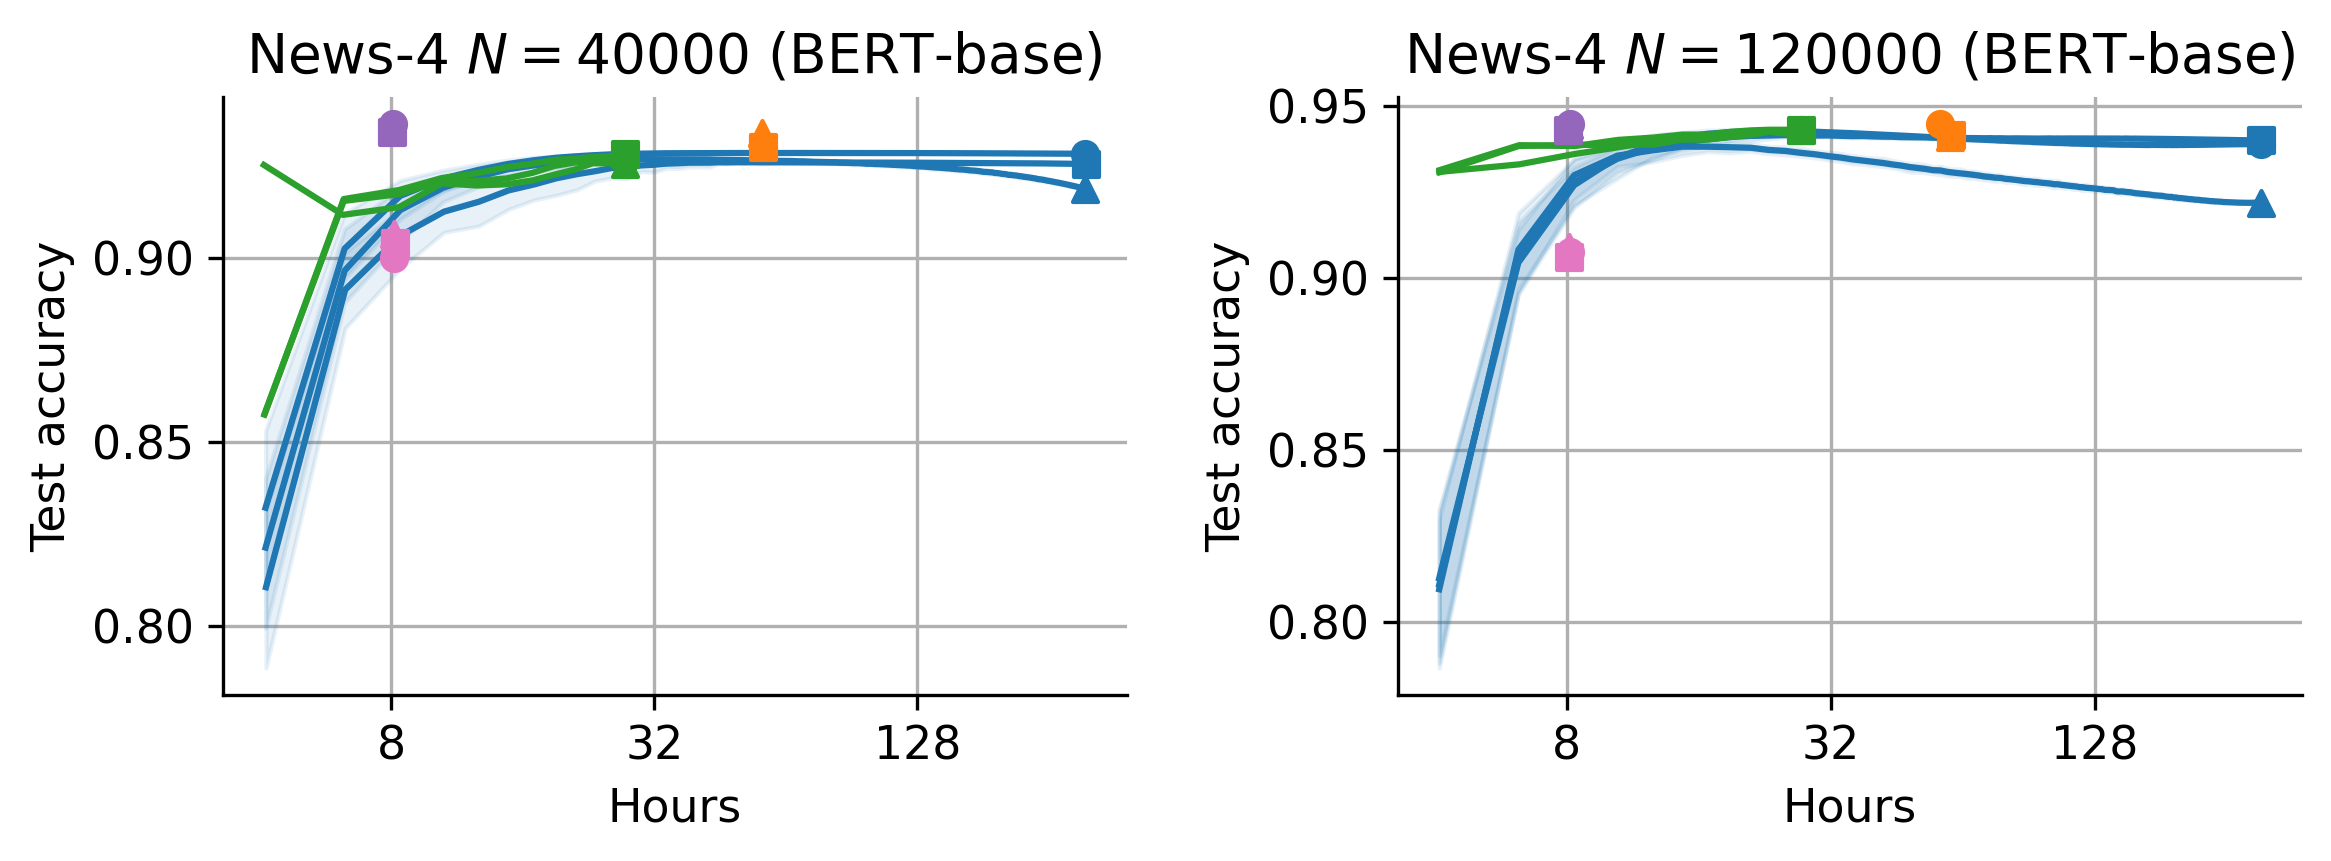

In [14]:
def break_axes(ax):
    d = 0.015
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (0.525 - d, 0.525 + d), **kwargs)
    ax.plot((-d, +d), (0.475 - d, 0.475 + d), **kwargs)
    
def decorate_ax(ax, title):
    ax.set_title(title)
    ax.set_xlabel('Hours')
    ax.set_ylabel('Test accuracy')
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xscale('log', base=2)
    ax_xticks = ax.get_xticks()
    ax.set_xticks([int(ax_xtick) for ax_xtick in ax_xticks[2:-2]], [int(ax_xtick) for ax_xtick in ax_xticks[2:-2]])
    ax.grid()
    
def decorate_hidden_ax(ax, title):
    ax.set_title(title)
    ax.set_xlabel('Hours')
    ax.set_ylabel('Test accuracy')
    ax.spines[['bottom', 'top', 'left', 'right']].set_visible(False)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax.tick_params(axis='x', color=(0, 0, 0, 0), labelcolor=(0, 0, 0, 0), which='both')
    ax.tick_params(axis='y', color=(0, 0, 0, 0), labelcolor=(0, 0, 0, 0), which='both')
    
def decorate_broken_axes(ax1, ax2):
    
    ax1.spines[['bottom', 'top', 'right']].set_visible(False)
    ax2.spines[['right', 'top']].set_visible(False)
        
    ax1.set_xscale('log', base=2)
    ax2.set_xscale('log', base=2)
    ax1_xlim = ax1.get_xlim()
    ax1_xticks = ax1.get_xticks()
    ax1.set_xticks([int(ax1_xtick) for ax1_xtick in ax1_xticks[2:-2]], [int(ax1_xtick) for ax1_xtick in ax1_xticks[2:-2]])
    ax1.tick_params(axis='x', color=(0, 0, 0, 0), labelcolor=(0, 0, 0, 0), which='both')
    ax2.set_xlim(ax1_xlim)
    ax2.set_xticks([int(ax1_xtick) for ax1_xtick in ax1_xticks[2:-2]], [int(ax1_xtick) for ax1_xtick in ax1_xticks[2:-2]])
    
    ax1_distance = ax1.get_ylim()[1] - ax1.get_ylim()[0]
    ax2_mean = sum(ax2.get_ylim())/2
    ax2_distance = [max(0.0, ax2_mean - (ax1_distance/2)), max(ax2_mean + (ax1_distance/2) - (ax2_mean - (ax1_distance/2)), ax2_mean + (ax1_distance/2))]
    ax2.scatter(4*np.ones_like(ax2_distance), ax2_distance, color='#FFFFFF')
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(round(ax1.get_yticks()[-1] - ax1.get_yticks()[-2], 3)))
    if len(ax2.get_yticks()) > 5:
        ax2.yaxis.set_major_locator(ticker.AutoLocator())
    ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    
    ax1.grid()
    ax2.grid()
    
markers = ['o', '^', 's']
    
ncols, nrows = 2, 1
fig, axs = plt.subplots(dpi=300, figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows)

# Plot 3
plot_dictionary(axs[0], news4_dictionary, 40000, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(news4_elbo_retrained_df[news4_elbo_retrained_df.n==40000].total_time.values/3600, news4_elbo_retrained_df[news4_elbo_retrained_df.n==40000].test_acc.values)):
    axs[0].scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(news4_laplace_retrained_df[news4_laplace_retrained_df.n==40000].total_time.values/3600, news4_laplace_retrained_df[news4_laplace_retrained_df.n==40000].test_acc.values)):
    axs[0].scatter(time, acc, color='#FF7F0E', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(news4_de_elbo_retrained_df[news4_de_elbo_retrained_df.n==40000].total_time.values/3600, news4_de_elbo_retrained_df[news4_de_elbo_retrained_df.n==40000].test_acc.values)):
    axs[0].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)

for index, random_state in enumerate([1001, 2001, 3001]):
    temp_df = new4_bo_grouped_df[(new4_bo_grouped_df.n==40000)&(new4_bo_grouped_df.random_state==random_state)]
    temp_df = temp_df.sort_values('n_iter')
    axs[0].scatter(temp_df.runtime_mean.values[-1]/3600, temp_df.test_acc_mean.values[-1], color='#2CA02C', marker=markers[index], zorder=2)
    axs[0].plot(temp_df.runtime_mean.values/3600, temp_df.test_acc_mean.values, color='#2CA02C', zorder=2)
    
decorate_ax(axs[0], r'News-4 $N=40000$ (BERT-base)')

# Plot 4
plot_dictionary(axs[1], news4_dictionary, 120_000, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(news4_elbo_retrained_df[news4_elbo_retrained_df.n==120_000].total_time.values/3600, news4_elbo_retrained_df[news4_elbo_retrained_df.n==120_000].test_acc.values)):
    axs[1].scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(news4_laplace_retrained_df[news4_laplace_retrained_df.n==120_000].total_time.values/3600, news4_laplace_retrained_df[news4_laplace_retrained_df.n==120_000].test_acc.values)):
    axs[1].scatter(time, acc, color='#FF7F0E', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(news4_de_elbo_retrained_df[news4_de_elbo_retrained_df.n==120_000].total_time.values/3600, news4_de_elbo_retrained_df[news4_de_elbo_retrained_df.n==120_000].test_acc.values)):
    axs[1].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)

for index, random_state in enumerate([1001, 2001, 3001]):
    temp_df = new4_bo_grouped_df[(new4_bo_grouped_df.n==120000)&(new4_bo_grouped_df.random_state==random_state)]
    temp_df = temp_df.sort_values('n_iter')
    axs[1].scatter(temp_df.runtime_mean.values[-1]/3600, temp_df.test_acc_mean.values[-1], color='#2CA02C', marker=markers[index], zorder=2)
    axs[1].plot(temp_df.runtime_mean.values/3600, temp_df.test_acc_mean.values, color='#2CA02C', zorder=2)
    
decorate_ax(axs[1], r'News-4 $N=120000$ (BERT-base)')

fig.tight_layout()
fig.savefig('computational_time_comparison2.pdf', bbox_inches='tight')
plt.show()

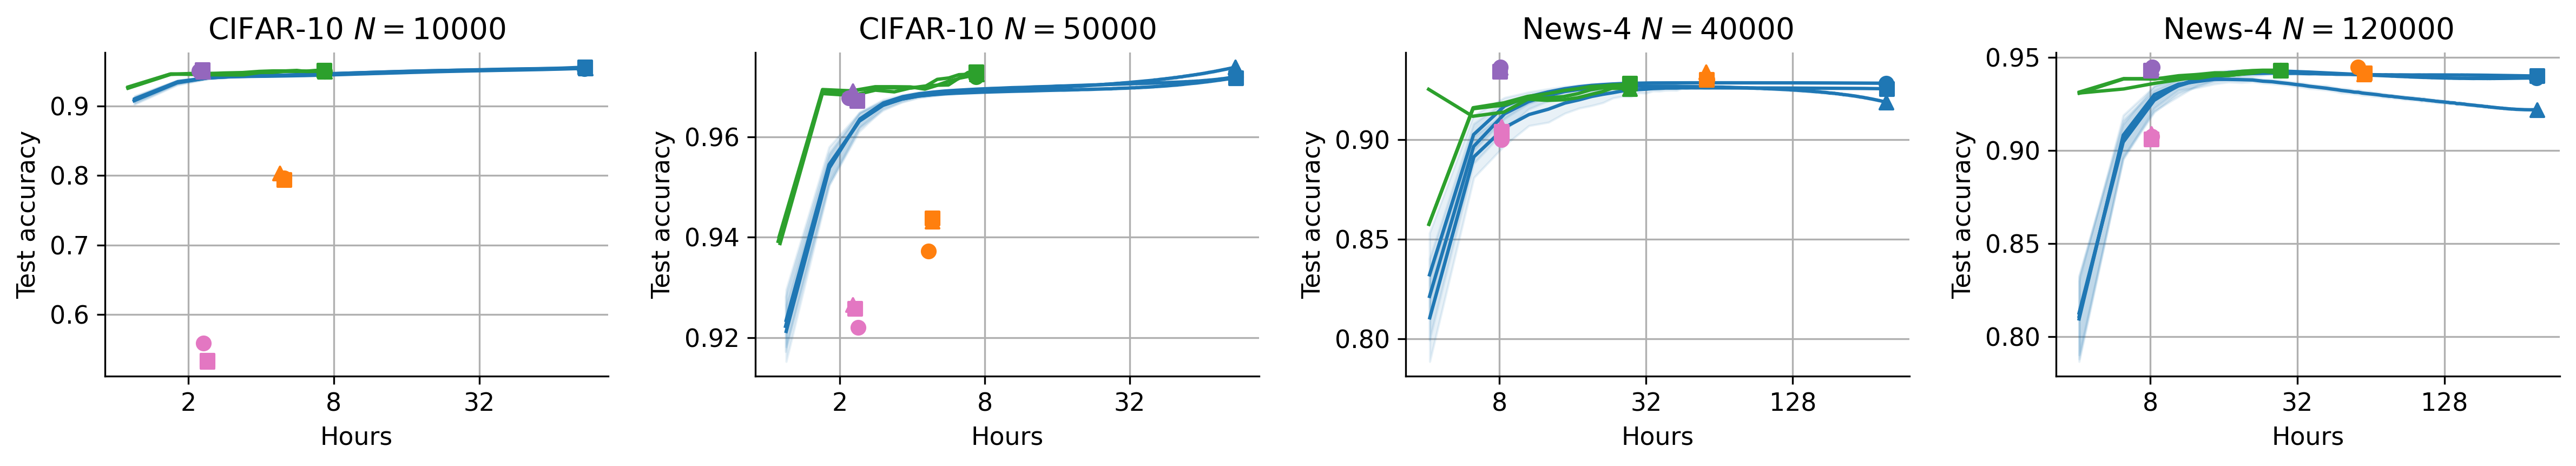

In [40]:
def break_axes(ax):
    d = 0.015
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (0.525 - d, 0.525 + d), **kwargs)
    ax.plot((-d, +d), (0.475 - d, 0.475 + d), **kwargs)
    
def decorate_ax(ax, title):
    ax.set_title(title)
    ax.set_xlabel('Hours')
    ax.set_ylabel('Test accuracy')
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xscale('log', base=2)
    ax_xticks = ax.get_xticks()
    ax.set_xticks([int(ax_xtick) for ax_xtick in ax_xticks[2:-2]], [int(ax_xtick) for ax_xtick in ax_xticks[2:-2]])
    ax.grid()
    
def decorate_hidden_ax(ax, title):
    ax.set_title(title)
    ax.set_xlabel('Hours')
    ax.set_ylabel('Test accuracy')
    ax.spines[['bottom', 'top', 'left', 'right']].set_visible(False)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax.tick_params(axis='x', color=(0, 0, 0, 0), labelcolor=(0, 0, 0, 0), which='both')
    ax.tick_params(axis='y', color=(0, 0, 0, 0), labelcolor=(0, 0, 0, 0), which='both')
    
def decorate_broken_axes(ax1, ax2):
    
    ax1.spines[['bottom', 'top', 'right']].set_visible(False)
    ax2.spines[['right', 'top']].set_visible(False)
        
    ax1.set_xscale('log', base=2)
    ax2.set_xscale('log', base=2)
    ax1_xlim = ax1.get_xlim()
    ax1_xticks = ax1.get_xticks()
    ax1.set_xticks([int(ax1_xtick) for ax1_xtick in ax1_xticks[2:-2]], [int(ax1_xtick) for ax1_xtick in ax1_xticks[2:-2]])
    ax1.tick_params(axis='x', color=(0, 0, 0, 0), labelcolor=(0, 0, 0, 0), which='both')
    ax2.set_xlim(ax1_xlim)
    ax2.set_xticks([int(ax1_xtick) for ax1_xtick in ax1_xticks[2:-2]], [int(ax1_xtick) for ax1_xtick in ax1_xticks[2:-2]])
    
    ax1_distance = ax1.get_ylim()[1] - ax1.get_ylim()[0]
    ax2_mean = sum(ax2.get_ylim())/2
    ax2_distance = [max(0.0, ax2_mean - (ax1_distance/2)), max(ax2_mean + (ax1_distance/2) - (ax2_mean - (ax1_distance/2)), ax2_mean + (ax1_distance/2))]
    ax2.scatter(4*np.ones_like(ax2_distance), ax2_distance, color='#FFFFFF')
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(round(ax1.get_yticks()[-1] - ax1.get_yticks()[-2], 3)))
    if len(ax2.get_yticks()) > 5:
        ax2.yaxis.set_major_locator(ticker.AutoLocator())
    ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    
    ax1.grid()
    ax2.grid()
    
markers = ['o', '^', 's']
    
ncols, nrows = 4, 1
fig, axs = plt.subplots(dpi=300, figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows)

# Plot 1
plot_dictionary(axs[0], cifar10_dictionary, 10000, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==10000].total_time.values/3600, cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==10000].test_acc.values)):
    axs[0].scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(cifar10_laplace_retrained_df[cifar10_laplace_retrained_df.n==10000].total_time.values/3600, cifar10_laplace_retrained_df[cifar10_laplace_retrained_df.n==10000].test_acc.values)):
    axs[0].scatter(time, acc, color='#FF7F0E', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(cifar10_de_elbo_retrained_df[cifar10_de_elbo_retrained_df.n==10000].total_time.values/3600, cifar10_de_elbo_retrained_df[cifar10_de_elbo_retrained_df.n==10000].test_acc.values)):
    axs[0].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
    
for index, random_state in enumerate([1001, 2001, 3001]):
    temp_df = cifar10_bo_grouped_df[(cifar10_bo_grouped_df.n==10000)&(cifar10_bo_grouped_df.random_state==random_state)]
    temp_df = temp_df.sort_values('n_iter')
    axs[0].scatter(temp_df.runtime_mean.values[-1]/3600, temp_df.test_acc_mean.values[-1], color='#2CA02C', marker=markers[index], zorder=2)
    axs[0].plot(temp_df.runtime_mean.values/3600, temp_df.test_acc_mean.values, color='#2CA02C', zorder=2)
    
decorate_ax(axs[0], r'CIFAR-10 $N=10000$')

# Plot 2
plot_dictionary(axs[1], cifar10_dictionary, 50000, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==50000].total_time.values/3600, cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==50000].test_acc.values)):
    axs[1].scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(cifar10_laplace_retrained_df[cifar10_laplace_retrained_df.n==50000].total_time.values/3600, cifar10_laplace_retrained_df[cifar10_laplace_retrained_df.n==50000].test_acc.values)):
    axs[1].scatter(time, acc, color='#FF7F0E', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(cifar10_de_elbo_retrained_df[cifar10_de_elbo_retrained_df.n==50000].total_time.values/3600, cifar10_de_elbo_retrained_df[cifar10_de_elbo_retrained_df.n==50000].test_acc.values)):
    axs[1].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
    
for index, random_state in enumerate([1001, 2001, 3001]):
    temp_df = cifar10_bo_grouped_df[(cifar10_bo_grouped_df.n==50000)&(cifar10_bo_grouped_df.random_state==random_state)]
    temp_df = temp_df.sort_values('n_iter')
    axs[1].scatter(temp_df.runtime_mean.values[-1]/3600, temp_df.test_acc_mean.values[-1], color='#2CA02C', marker=markers[index], zorder=2)
    axs[1].plot(temp_df.runtime_mean.values/3600, temp_df.test_acc_mean.values, color='#2CA02C', zorder=2)
    
decorate_ax(axs[1], r'CIFAR-10 $N=50000$')

# Plot 3
plot_dictionary(axs[2], news4_dictionary, 40000, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(news4_elbo_retrained_df[news4_elbo_retrained_df.n==40000].total_time.values/3600, news4_elbo_retrained_df[news4_elbo_retrained_df.n==40000].test_acc.values)):
    axs[2].scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(news4_laplace_retrained_df[news4_laplace_retrained_df.n==40000].total_time.values/3600, news4_laplace_retrained_df[news4_laplace_retrained_df.n==40000].test_acc.values)):
    axs[2].scatter(time, acc, color='#FF7F0E', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(news4_de_elbo_retrained_df[news4_de_elbo_retrained_df.n==40000].total_time.values/3600, news4_de_elbo_retrained_df[news4_de_elbo_retrained_df.n==40000].test_acc.values)):
    axs[2].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)

for index, random_state in enumerate([1001, 2001, 3001]):
    temp_df = new4_bo_grouped_df[(new4_bo_grouped_df.n==40000)&(new4_bo_grouped_df.random_state==random_state)]
    temp_df = temp_df.sort_values('n_iter')
    axs[2].scatter(temp_df.runtime_mean.values[-1]/3600, temp_df.test_acc_mean.values[-1], color='#2CA02C', marker=markers[index], zorder=2)
    axs[2].plot(temp_df.runtime_mean.values/3600, temp_df.test_acc_mean.values, color='#2CA02C', zorder=2)
    
decorate_ax(axs[2], r'News-4 $N=40000$')

# Plot 4
plot_dictionary(axs[3], news4_dictionary, 120_000, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(news4_elbo_retrained_df[news4_elbo_retrained_df.n==120_000].total_time.values/3600, news4_elbo_retrained_df[news4_elbo_retrained_df.n==120_000].test_acc.values)):
    axs[3].scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(news4_laplace_retrained_df[news4_laplace_retrained_df.n==120_000].total_time.values/3600, news4_laplace_retrained_df[news4_laplace_retrained_df.n==120_000].test_acc.values)):
    axs[3].scatter(time, acc, color='#FF7F0E', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(news4_de_elbo_retrained_df[news4_de_elbo_retrained_df.n==120_000].total_time.values/3600, news4_de_elbo_retrained_df[news4_de_elbo_retrained_df.n==120_000].test_acc.values)):
    axs[3].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)

for index, random_state in enumerate([1001, 2001, 3001]):
    temp_df = new4_bo_grouped_df[(new4_bo_grouped_df.n==120000)&(new4_bo_grouped_df.random_state==random_state)]
    temp_df = temp_df.sort_values('n_iter')
    axs[3].scatter(temp_df.runtime_mean.values[-1]/3600, temp_df.test_acc_mean.values[-1], color='#2CA02C', marker=markers[index], zorder=2)
    axs[3].plot(temp_df.runtime_mean.values/3600, temp_df.test_acc_mean.values, color='#2CA02C', zorder=2)
    
decorate_ax(axs[3], r'News-4 $N=120000$')

fig.tight_layout()
plt.show()

In [41]:
def subsample_hyperparameters(ns, retrained_df, random_states=[1001, 2001, 3001]):
    
    dictionary = {
        n: {
            random_state: np.zeros((100, 3, 500, 2)) for random_state in random_states
        } for n in ns
    }
    
    for n, random_state in itertools.product(ns, random_states):
        for subsample_round_index in range(100):
            for num_hypers in range(2,5):
                for subsample_index in range(500):
                    condition = (retrained_df.criterion=='l2-sp')&(retrained_df.n==n)&(retrained_df.random_state==random_state)
                    sampled_retrained_df = retrained_df.loc[condition].sample(n=num_hypers)
                    runtime = sampled_retrained_df.runtime.sum()
                    test_acc = sampled_retrained_df.loc[sampled_retrained_df.train_loss.idxmin(), 'test_acc'].item()
                    dictionary[n][random_state][subsample_round_index,num_hypers-2,subsample_index,0] = runtime
                    dictionary[n][random_state][subsample_round_index,num_hypers-2,subsample_index,1] = test_acc

    return dictionary

#cifar10_de_elbo_dictionary = subsample_hyperparameters([10000, 50000], cifar10_de_elbo_tuned_df)
#news4_de_elbo_dictionary = subsample_hyperparameters([40000, 120000], news4_de_elbo_tuned_df)

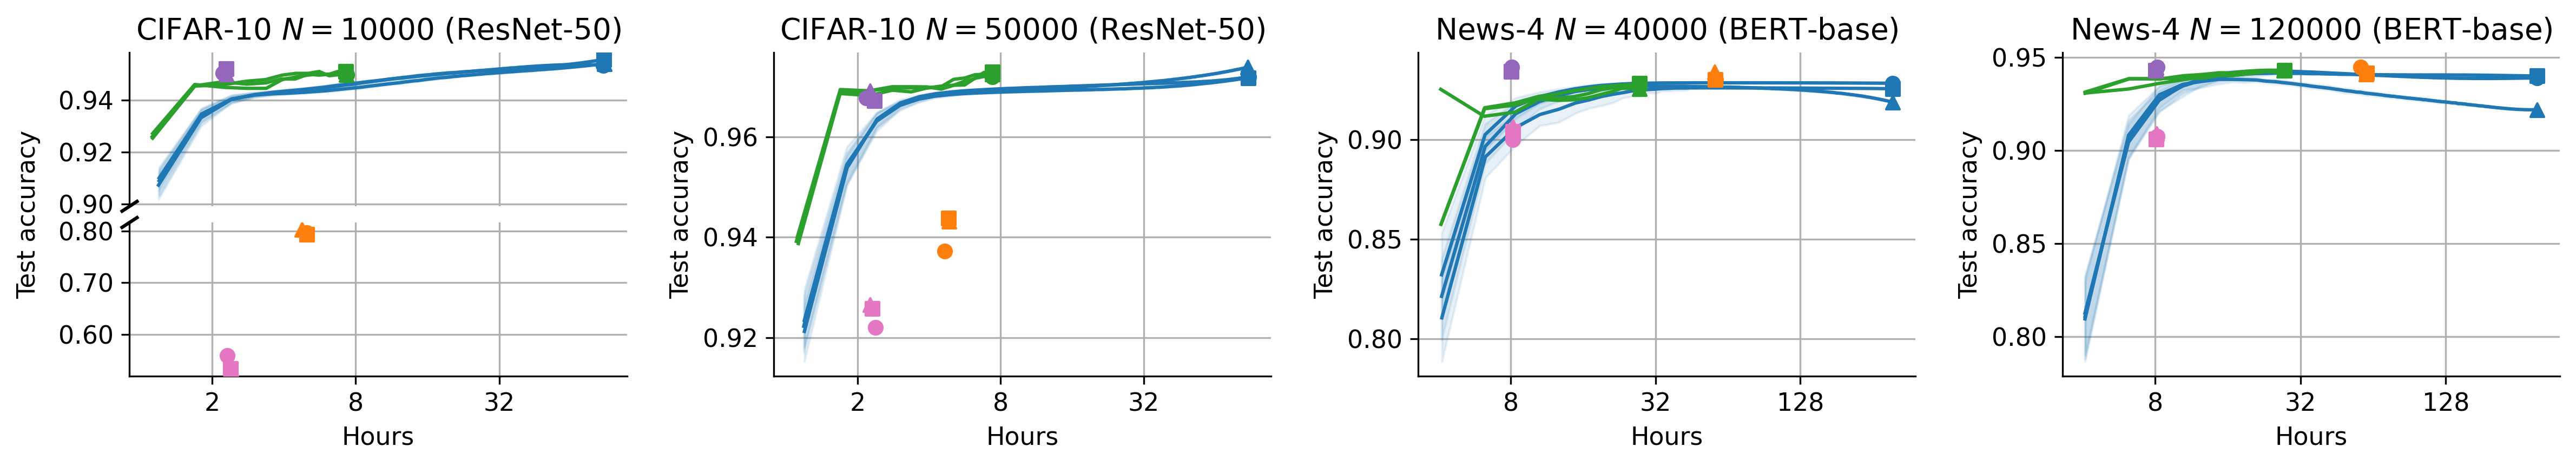

In [42]:
def break_axes(ax):
    d = 0.015
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (0.525 - d, 0.525 + d), **kwargs)
    ax.plot((-d, +d), (0.475 - d, 0.475 + d), **kwargs)
    
def decorate_ax(ax, title):
    ax.set_title(title)
    ax.set_xlabel('Hours')
    ax.set_ylabel('Test accuracy')
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xscale('log', base=2)
    ax_xticks = ax.get_xticks()
    ax.set_xticks([int(ax_xtick) for ax_xtick in ax_xticks[2:-2]], [int(ax_xtick) for ax_xtick in ax_xticks[2:-2]])
    ax.grid()
    
def decorate_hidden_ax(ax, title):
    ax.set_title(title)
    ax.set_xlabel('Hours')
    ax.set_ylabel('Test accuracy')
    ax.spines[['bottom', 'top', 'left', 'right']].set_visible(False)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax.tick_params(axis='x', color=(0, 0, 0, 0), labelcolor=(0, 0, 0, 0), which='both')
    ax.tick_params(axis='y', color=(0, 0, 0, 0), labelcolor=(0, 0, 0, 0), which='both')
    
def decorate_broken_axes(ax1, ax2):
    
    ax1.spines[['bottom', 'top', 'right']].set_visible(False)
    ax2.spines[['right', 'top']].set_visible(False)
        
    ax1.set_xscale('log', base=2)
    ax2.set_xscale('log', base=2)
    ax1_xlim = ax1.get_xlim()
    ax1_xticks = ax1.get_xticks()
    ax1.set_xticks([int(ax1_xtick) for ax1_xtick in ax1_xticks[2:-2]], [int(ax1_xtick) for ax1_xtick in ax1_xticks[2:-2]])
    ax1.tick_params(axis='x', color=(0, 0, 0, 0), labelcolor=(0, 0, 0, 0), which='both')
    ax2.set_xlim(ax1_xlim)
    ax2.set_xticks([int(ax1_xtick) for ax1_xtick in ax1_xticks[2:-2]], [int(ax1_xtick) for ax1_xtick in ax1_xticks[2:-2]])
    
    ax1_distance = ax1.get_ylim()[1] - ax1.get_ylim()[0]
    ax2_mean = sum(ax2.get_ylim())/2
    ax2_distance = [max(0.0, ax2_mean - (ax1_distance/2)), max(ax2_mean + (ax1_distance/2) - (ax2_mean - (ax1_distance/2)), ax2_mean + (ax1_distance/2))]
    ax2.scatter(4*np.ones_like(ax2_distance), ax2_distance, color='#FFFFFF')
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(round(ax1.get_yticks()[-1] - ax1.get_yticks()[-2], 3)))
    if len(ax2.get_yticks()) > 5:
        ax2.yaxis.set_major_locator(ticker.AutoLocator())
    ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    
    ax1.grid()
    ax2.grid()
    
markers = ['o', '^', 's']
    
ncols, nrows = 4, 1
fig, axs = plt.subplots(dpi=300, figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows)

# Plot 1
decorate_hidden_ax(axs[0], r'CIFAR-10 $N=10000$ (ResNet-50)')

ins1_top = axs[0].inset_axes([0.0, 0.525, 1.0, 0.475], zorder=1)
ins1_bottom = axs[0].inset_axes([0.0, 0.0, 1.0, 0.475], zorder=1)


plot_dictionary(ins1_top, cifar10_dictionary, 10000, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==10000].total_time.values/3600, cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==10000].test_acc.values)):
    ins1_bottom.scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(cifar10_laplace_retrained_df[cifar10_laplace_retrained_df.n==10000].total_time.values/3600, cifar10_laplace_retrained_df[cifar10_laplace_retrained_df.n==10000].test_acc.values)):
    ins1_bottom.scatter(time, acc, color='#FF7F0E', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(cifar10_de_elbo_retrained_df[cifar10_de_elbo_retrained_df.n==10000].total_time.values/3600, cifar10_de_elbo_retrained_df[cifar10_de_elbo_retrained_df.n==10000].test_acc.values)):
    ins1_top.scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
    
for index, random_state in enumerate([1001, 2001, 3001]):
    temp_df = cifar10_bo_grouped_df[(cifar10_bo_grouped_df.n==10000)&(cifar10_bo_grouped_df.random_state==random_state)]
    temp_df = temp_df.sort_values('n_iter')
    ins1_top.scatter(temp_df.runtime_mean.values[-1]/3600, temp_df.test_acc_mean.values[-1], color='#2CA02C', marker=markers[index], zorder=2)
    ins1_top.plot(temp_df.runtime_mean.values/3600, temp_df.test_acc_mean.values, color='#2CA02C', zorder=2)
    
break_axes(axs[0])
decorate_broken_axes(ins1_top, ins1_bottom)    

# Plot 2
plot_dictionary(axs[1], cifar10_dictionary, 50000, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==50000].total_time.values/3600, cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==50000].test_acc.values)):
    axs[1].scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(cifar10_laplace_retrained_df[cifar10_laplace_retrained_df.n==50000].total_time.values/3600, cifar10_laplace_retrained_df[cifar10_laplace_retrained_df.n==50000].test_acc.values)):
    axs[1].scatter(time, acc, color='#FF7F0E', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(cifar10_de_elbo_retrained_df[cifar10_de_elbo_retrained_df.n==50000].total_time.values/3600, cifar10_de_elbo_retrained_df[cifar10_de_elbo_retrained_df.n==50000].test_acc.values)):
    axs[1].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
    
for index, random_state in enumerate([1001, 2001, 3001]):
    temp_df = cifar10_bo_grouped_df[(cifar10_bo_grouped_df.n==50000)&(cifar10_bo_grouped_df.random_state==random_state)]
    temp_df = temp_df.sort_values('n_iter')
    axs[1].scatter(temp_df.runtime_mean.values[-1]/3600, temp_df.test_acc_mean.values[-1], color='#2CA02C', marker=markers[index], zorder=2)
    axs[1].plot(temp_df.runtime_mean.values/3600, temp_df.test_acc_mean.values, color='#2CA02C', zorder=2)
    
decorate_ax(axs[1], r'CIFAR-10 $N=50000$ (ResNet-50)')

# Plot 3
plot_dictionary(axs[2], news4_dictionary, 40000, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(news4_elbo_retrained_df[news4_elbo_retrained_df.n==40000].total_time.values/3600, news4_elbo_retrained_df[news4_elbo_retrained_df.n==40000].test_acc.values)):
    axs[2].scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(news4_laplace_retrained_df[news4_laplace_retrained_df.n==40000].total_time.values/3600, news4_laplace_retrained_df[news4_laplace_retrained_df.n==40000].test_acc.values)):
    axs[2].scatter(time, acc, color='#FF7F0E', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(news4_de_elbo_retrained_df[news4_de_elbo_retrained_df.n==40000].total_time.values/3600, news4_de_elbo_retrained_df[news4_de_elbo_retrained_df.n==40000].test_acc.values)):
    axs[2].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)

for index, random_state in enumerate([1001, 2001, 3001]):
    temp_df = new4_bo_grouped_df[(new4_bo_grouped_df.n==40000)&(new4_bo_grouped_df.random_state==random_state)]
    temp_df = temp_df.sort_values('n_iter')
    axs[2].scatter(temp_df.runtime_mean.values[-1]/3600, temp_df.test_acc_mean.values[-1], color='#2CA02C', marker=markers[index], zorder=2)
    axs[2].plot(temp_df.runtime_mean.values/3600, temp_df.test_acc_mean.values, color='#2CA02C', zorder=2)
    
decorate_ax(axs[2], r'News-4 $N=40000$ (BERT-base)')

# Plot 4
plot_dictionary(axs[3], news4_dictionary, 120_000, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(news4_elbo_retrained_df[news4_elbo_retrained_df.n==120_000].total_time.values/3600, news4_elbo_retrained_df[news4_elbo_retrained_df.n==120_000].test_acc.values)):
    axs[3].scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(news4_laplace_retrained_df[news4_laplace_retrained_df.n==120_000].total_time.values/3600, news4_laplace_retrained_df[news4_laplace_retrained_df.n==120_000].test_acc.values)):
    axs[3].scatter(time, acc, color='#FF7F0E', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(news4_de_elbo_retrained_df[news4_de_elbo_retrained_df.n==120_000].total_time.values/3600, news4_de_elbo_retrained_df[news4_de_elbo_retrained_df.n==120_000].test_acc.values)):
    axs[3].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)

for index, random_state in enumerate([1001, 2001, 3001]):
    temp_df = new4_bo_grouped_df[(new4_bo_grouped_df.n==120000)&(new4_bo_grouped_df.random_state==random_state)]
    temp_df = temp_df.sort_values('n_iter')
    axs[3].scatter(temp_df.runtime_mean.values[-1]/3600, temp_df.test_acc_mean.values[-1], color='#2CA02C', marker=markers[index], zorder=2)
    axs[3].plot(temp_df.runtime_mean.values/3600, temp_df.test_acc_mean.values, color='#2CA02C', zorder=2)
    
decorate_ax(axs[3], r'News-4 $N=120000$ (BERT-base)')

fig.tight_layout()
fig.savefig('computational_time_comparison1.pdf', bbox_inches='tight')
plt.show()